CORRELATION

Importing packages

In [16]:
import statsmodels.graphics.api as sga
import statsmodels.stats.api as ssa
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re
import pathlib
import numpy as np
import pandas as pd
import os
import glob
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
sns.set()

---
>> **TASK**
>>
>> Repetition of data analysis presented in the article.
>>
>> Article: bioa/exam/A4/Shao2017_Correlation_of_choroidal_thickness.pdf
>>
>> Summary:
>>
>> Analysis of choroidal thickness (CT)
>>
>>    -  Correlation and linear regression of CT with refractive error (RE), axial length (AL) and age (AGE)
>>    -  CT measured in 5 places in 1mm steps (T1 T2 SF N1 N2)
>>
>>
---

## Data

    - Sex
    - Age
    - l/r   - left and right eye measurement
    - RE    - refractive error
    - SE    - spherical equivalence
    - CV    - corrected visual acuity
    - AL    - axial length
    - CT    - weights at T1 T2 SF N1 and N2

Table df

In [17]:
df = pd.read_csv(
    '~/Documents/bioa/exam/A4/Shao2017_Correlation_of_choroidal_thickness.csv')

In [18]:
df.columns

Index(['Sex', 'Age', 'l/r', 'RE', 'SE', 'CV', 'AL', 'T2', 'T1', 'SF', 'N1',
       'N2'],
      dtype='object')

In [19]:
df.shape

(101, 12)

In [20]:
df.dtypes

Sex     object
Age      int64
l/r     object
RE     float64
SE     float64
CV     float64
AL     float64
T2       int64
T1       int64
SF       int64
N1       int64
N2       int64
dtype: object

In [21]:
df.head()

,Sex,Age,l/r,RE,SE,CV,AL,T2,T1,SF,N1,N2
0,male,8,od,0.00,0.625,1.0,23.46,289,309,314,248,203
1,male,8,os,0.00,0.750,1.0,23.53,274,287,289,277,207
2,female,13,od,-3.50,-4.250,0.8,24.38,191,217,258,257,239
3,female,13,os,-4.00,-5.000,0.8,25.11,186,216,238,230,211
4,male,10,od,-0.25,0.000,1.0,23.33,339,332,326,281,236


---
>> **TASK** (2 pts)
>>
>> 1. Data description
>>
>> a) Reproduce Table 1 (1 pts)
>>
>> b) Reproduce first paragraph of the 'Results' (1 pts)
>>
>>
---

In [22]:
table1 = pd.DataFrame(columns=['CT (Mean)', '$\pm$sd'], index=['2mm temporal to fovea (T2)',
                                                         '1mm temoral to fovea (T1)', 'subfovea (SF)', '1mm nasal to fovea (N1)', '2mm nasal to fovea (N2)'])
table1.index.name = 'Measurement location'
table1.iloc[0, 0] = df['T2'].mean()
table1.iloc[0, 1] = df['T2'].std()
table1.iloc[1, 0] = df['T1'].mean()
table1.iloc[1, 1] = df['T1'].std()
table1.iloc[2, 0] = df['SF'].mean()
table1.iloc[2, 1] = df['SF'].std()
table1.iloc[3, 0] = df['N1'].mean()
table1.iloc[3, 1] = df['N1'].std()
table1.iloc[4, 0] = df['N2'].mean()
table1.iloc[4, 1] = df['N2'].std()
print(f'a) Talbe 1. Choroidal Thickness (CT) of each measurement location.')
table1

a) Talbe 1. Choroidal Thickness (CT) of each measurement location.


,CT (Mean),$\pm$sd
Measurement location,,
2mm temporal to fovea (T2),295.772,58.1704
1mm temoral to fovea (T1),291.337,62.7338
subfovea (SF),286.772,70.4478
1mm nasal to fovea (N1),247.168,64.9948
2mm nasal to fovea (N2),200.782,59.0143


In [23]:
dfod = df[df['l/r'] == 'od']
dfod.columns
dfod['Sex'].value_counts()
dfod['Age'].mean()
dfod['Age'].std()

2.7782065028627767

In [24]:
print(f'b) There were {dfod["Age"].count()} subjects participated in this research, including {dfod["Sex"].value_counts().male} boys and  {dfod["Sex"].value_counts().female} girls.\
The mean age was {dfod["Age"].mean():.2f} \u00B1 {dfod["Age"].std():.2f} years (ranged from {dfod["Age"].min()} to {dfod["Age"].max()} years).\
The mean of spherical equivalent refractive error was {dfod["RE"].mean():.2f}D ± {dfod["RE"].std():.2f}D\
(ranged from {dfod["RE"].min()}D to {dfod["RE"].max()}D).\
The average axial length was {dfod["AL"].mean():.2f} \u00B1 {dfod["AL"].std():.2f}mm\
(ranged from {dfod["AL"].min()}mm to {dfod["AL"].max()}mm).')

b) There were 51 subjects participated in this research, including 26 boys and  25 girls.The mean age was 10.04 ± 2.78 years (ranged from 5 to 18 years).The mean of spherical equivalent refractive error was -1.66D ± 1.57D(ranged from -7.5D to 0.75D).The average axial length was 24.14 ± 1.14mm(ranged from 21.9mm to 27.4mm).


---
>> **TASK**
>>
>> 2. Correlations (2 pts)
>>
>> Reproduce Table 2. Correlation...
>>
---

In [25]:
table2a = pd.DataFrame(columns=['Pearson with RE', '$R^2$', 'p value'], index=[
                      '$CT_{N2}$', '$CT_{N1}$', '$CT_{SF}$', '$CT_{T1}$', '$CT_{T2}$'])
table2b = pd.DataFrame(columns=['Pearson with AL', '$R^2$', 'p value'], index=[
                      '$CT_{N2}$', '$CT_{N1}$', '$CT_{SF}$', '$CT_{T1}$', '$CT_{T2}$'])
table2c = pd.DataFrame(columns=['Pearson with age', '$R^2$', 'p value'], index=[
                      '$CT_{N2}$', '$CT_{N1}$', '$CT_{SF}$', '$CT_{T1}$', '$CT_{T2}$'])

In [26]:
table2c.iloc[0, 0] = stats.pearsonr(df['Age'], df['N2'])[0]
table2c.iloc[1, 0] = stats.pearsonr(df['Age'], df['N1'])[0]
table2c.iloc[2, 0] = stats.pearsonr(df['Age'], df['SF'])[0]
table2c.iloc[3, 0] = stats.pearsonr(df['Age'], df['T1'])[0]
table2c.iloc[4, 0] = stats.pearsonr(df['Age'], df['T2'])[0]

In [27]:
table2c.iloc[0, 1] = stats.pearsonr(df['Age'], df['N2'])[0]**2
table2c.iloc[1, 1] = stats.pearsonr(df['Age'], df['N1'])[0]**2
table2c.iloc[2, 1] = stats.pearsonr(df['Age'], df['SF'])[0]**2
table2c.iloc[3, 1] = stats.pearsonr(df['Age'], df['T1'])[0]**2
table2c.iloc[4, 1] = stats.pearsonr(df['Age'], df['T2'])[0]**2

In [28]:
table2c.iloc[0, 2] = stats.pearsonr(df['Age'], df['N2'])[1]
table2c.iloc[1, 2] = stats.pearsonr(df['Age'], df['N1'])[1]
table2c.iloc[2, 2] = stats.pearsonr(df['Age'], df['SF'])[1]
table2c.iloc[3, 2] = stats.pearsonr(df['Age'], df['T1'])[1]
table2c.iloc[4, 2] = stats.pearsonr(df['Age'], df['T2'])[1]

In [29]:
table2a.iloc[0, 0] = stats.pearsonr(df['RE'], df['N2'])[0]
table2a.iloc[1, 0] = stats.pearsonr(df['RE'], df['N1'])[0]
table2a.iloc[2, 0] = stats.pearsonr(df['RE'], df['SF'])[0]
table2a.iloc[3, 0] = stats.pearsonr(df['RE'], df['T1'])[0]
table2a.iloc[4, 0] = stats.pearsonr(df['RE'], df['T2'])[0]

In [30]:
table2a.iloc[0, 1] = stats.pearsonr(df['RE'], df['N2'])[0]**2
table2a.iloc[1, 1] = stats.pearsonr(df['RE'], df['N1'])[0]**2
table2a.iloc[2, 1] = stats.pearsonr(df['RE'], df['SF'])[0]**2
table2a.iloc[3, 1] = stats.pearsonr(df['RE'], df['T1'])[0]**2
table2a.iloc[4, 1] = stats.pearsonr(df['RE'], df['T2'])[0]**2

In [31]:
table2a.iloc[0, 2] = stats.pearsonr(df['RE'], df['N2'])[1]
table2a.iloc[1, 2] = stats.pearsonr(df['RE'], df['N1'])[1]
table2a.iloc[2, 2] = stats.pearsonr(df['RE'], df['SF'])[1]
table2a.iloc[3, 2] = stats.pearsonr(df['RE'], df['T1'])[1]
table2a.iloc[4, 2] = stats.pearsonr(df['RE'], df['T2'])[1]

In [32]:
table2b.iloc[0, 0] = stats.pearsonr(df['AL'], df['N2'])[0]
table2b.iloc[1, 0] = stats.pearsonr(df['AL'], df['N1'])[0]
table2b.iloc[2, 0] = stats.pearsonr(df['AL'], df['SF'])[0]
table2b.iloc[3, 0] = stats.pearsonr(df['AL'], df['T1'])[0]
table2b.iloc[4, 0] = stats.pearsonr(df['AL'], df['T2'])[0]

In [33]:
table2b.iloc[0, 1] = stats.pearsonr(df['AL'], df['N2'])[0]**2
table2b.iloc[1, 1] = stats.pearsonr(df['AL'], df['N1'])[0]**2
table2b.iloc[2, 1] = stats.pearsonr(df['AL'], df['SF'])[0]**2
table2b.iloc[3, 1] = stats.pearsonr(df['AL'], df['T1'])[0]**2
table2b.iloc[4, 1] = stats.pearsonr(df['AL'], df['T2'])[0]**2

In [34]:
table2b.iloc[0, 2] = stats.pearsonr(df['AL'], df['N2'])[1]
table2b.iloc[1, 2] = stats.pearsonr(df['AL'], df['N1'])[1]
table2b.iloc[2, 2] = stats.pearsonr(df['AL'], df['SF'])[1]
table2b.iloc[3, 2] = stats.pearsonr(df['AL'], df['T1'])[1]
table2b.iloc[4, 2] = stats.pearsonr(df['AL'], df['T2'])[1]

In [35]:
table2 = pd.concat([table2a, table2b, table2c], axis=1)

In [36]:
table2['p value']

,p value,p value,p value
$CT_{N2}$,0.00171325,7.2139e-05,0.160396
$CT_{N1}$,2.96031e-05,1.01084e-05,0.00713379
$CT_{SF}$,1.16688e-05,1.54278e-05,0.00782864
$CT_{T1}$,0.000337928,0.00236105,0.0527605
$CT_{T2}$,0.00639411,0.0587806,0.0917076


In [37]:
print(f'Table 2. Correlation analysis between choroidal thickness of each point and Refractive Error (RE), Axial Length (AL) and age')
table2

Table 2. Correlation analysis between choroidal thickness of each point and Refractive Error (RE), Axial Length (AL) and age


,Pearson with RE,$R^2$,p value,Pearson with AL,$R^2$,p value,Pearson with age,$R^2$,p value
$CT_{N2}$,0.308236,0.0950097,0.00171325,-0.384438,0.147792,7.2139e-05,-0.140733,0.0198058,0.160396
$CT_{N1}$,0.402841,0.162281,2.96031e-05,-0.42369,0.179513,1.01084e-05,-0.266183,0.0708535,0.00713379
$CT_{SF}$,0.420983,0.177227,1.16688e-05,-0.41565,0.172765,1.54278e-05,-0.26321,0.0692797,0.00782864
$CT_{T1}$,0.349679,0.122276,0.000337928,-0.299309,0.0895858,0.00236105,-0.193311,0.037369,0.0527605
$CT_{T2}$,0.269643,0.0727076,0.00639411,-0.188701,0.035608,0.0587806,-0.168704,0.0284609,0.0917076


---
>> **TASK**
>>
>> 3. Regression (2 pts)
>>
>> Reproduce Table 3. Multiple... 
>>
>> In the article authors performed regression in two steps:
>>    1. Calculated simple linear regression with 1 dependent and 1 independent variable
>>    2. Calculated multiple linear regression by adding one more variable.
>>
>> No need to compare models.
>>
>>    - $multiple R$ is a square root of $R^2$
>>
---

In [38]:
table3 = pd.DataFrame(columns=['$R$', '$R^2$', '$F$', '$p$'], index=[
                     'SF step 1 AL', 'SF step 2 AGE', 'N1 step 1 AL', 'N1 step 2 AGE'])

In [39]:
formula = 'SF ~ AL'
res1 = smf.ols(formula, data=df).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SF   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     20.68
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           1.54e-05
Time:                        15:27:56   Log-Likelihood:                -562.97
No. Observations:                 101   AIC:                             1130.
Df Residuals:                      99   BIC:                             1135.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    905.0636    136.127      6.649      0.000     634.959    1175.168
AL           -25.6017      5.630     -4.547      0.000     -36.774     -14.430
==============================================================================
Omnibus:                        3.080   Durbin-Watson:                   1.360
Prob(Omnibus):                  0.214   Jarque-Bera (JB):                2.698
Skew:                           0.399   Prob(JB):                        0.260
Kurtosis:                       3.075   Cond. No.                         515.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
table3.iloc[0, 0] = np.sqrt(res1.rsquared)
table3.iloc[0, 1] = res1.rsquared
table3.iloc[0, 2] = res1.fvalue
table3.iloc[0, 3] = res1.f_pvalue

In [41]:
formula = 'SF ~ AL+Age'
res2 = smf.ols(formula, data=df).fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     SF   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     10.26
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           8.99e-05
Time:                        15:27:56   Log-Likelihood:                -562.95
No. Observations:                 101   AIC:                             1132.
Df Residuals:                      98   BIC:                             1140.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    889.6478    154.631      5.753      0.000     582.788    1196.507
AL           -24.7056      7.041     -3.509      0.001     -38.679     -10.733
Age           -0.6213      2.906     -0.214      0.831      -6.388       5.146
==============================================================================
Omnibus:                        2.983   Durbin-Watson:                   1.365
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                2.571
Skew:                           0.388   Prob(JB):                        0.277
Kurtosis:                       3.097   Cond. No.                         631.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
table3.iloc[1, 0] = np.sqrt(res2.rsquared)
table3.iloc[1, 1] = res2.rsquared
table3.iloc[1, 2] = res2.fvalue
table3.iloc[1, 3] = res2.pvalues.Age

In [43]:
formula = 'N1 ~ AL'
res = smf.ols(formula, data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     N1   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     21.66
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           1.01e-05
Time:                        15:27:56   Log-Likelihood:                -554.42
No. Observations:                 101   AIC:                             1113.
Df Residuals:                      99   BIC:                             1118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    828.6334    125.076      6.625      0.000     580.455    1076.812
AL           -24.0768      5.173     -4.654      0.000     -34.342     -13.812
==============================================================================
Omnibus:                        2.509   Durbin-Watson:                   1.272
Prob(Omnibus):                  0.285   Jarque-Bera (JB):                2.199
Skew:                           0.361   Prob(JB):                        0.333
Kurtosis:                       3.028   Cond. No.                         515.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
table3.iloc[2, 0] = np.sqrt(res.rsquared)
table3.iloc[2, 1] = res.rsquared
table3.iloc[2, 2] = res.fvalue
table3.iloc[2, 3] = res.f_pvalue

In [45]:
formula = 'N1 ~ AL+Age'
res = smf.ols(formula, data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     N1   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     10.74
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           6.05e-05
Time:                        15:27:57   Log-Likelihood:                -554.40
No. Observations:                 101   AIC:                             1115.
Df Residuals:                      98   BIC:                             1123.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    816.0451    142.085      5.743      0.000     534.081    1098.009
AL           -23.3451      6.470     -3.608      0.000     -36.185     -10.506
Age           -0.5073      2.670     -0.190      0.850      -5.806       4.792
==============================================================================
Omnibus:                        2.447   Durbin-Watson:                   1.278
Prob(Omnibus):                  0.294   Jarque-Bera (JB):                2.097
Skew:                           0.352   Prob(JB):                        0.350
Kurtosis:                       3.059   Cond. No.                         631.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
table3.iloc[3, 0] = np.sqrt(res.rsquared)
table3.iloc[3, 1] = res.rsquared
table3.iloc[3, 2] = res.fvalue
table3.iloc[3, 3] = res.pvalues.Age

In [47]:
print(f'Talbe 3. Multiple regression of CT (sf and n1) with age and AL')
table3

Talbe 3. Multiple regression of CT (sf and n1) with age and AL


,$R$,$R^2$,$F$,$p$
SF step 1 AL,0.41565,0.172765,20.6758,1.54278e-05
SF step 2 AGE,0.416114,0.173151,10.2611,0.831161
N1 step 1 AL,0.42369,0.179513,21.6601,1.01084e-05
N1 step 2 AGE,0.424046,0.179815,10.7426,0.849713


---
>> **TASK**
>>
>> 4. Graphs (2 pts)
>>
>> a) Reproduce text and image of Fig 2. Linear... (1 pts)
>>
>> b) Reproduce text and image of Fig 3. The scatter plot... (1pts)
>>
>>
---

 a)

In [48]:
formula = 'RE ~ AL'
res = smf.ols(formula, data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RE   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     90.93
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           1.13e-15
Time:                        15:27:59   Log-Likelihood:                -152.84
No. Observations:                 101   AIC:                             309.7
Df Residuals:                      99   BIC:                             314.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.6556      2.346      8.804      0.000      16.000      25.311
AL            -0.9254      0.097     -9.536      0.000      -1.118      -0.733
==============================================================================
Omnibus:                       18.667   Durbin-Watson:                   1.169
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.968
Skew:                          -0.941   Prob(JB):                     6.24e-06
Kurtosis:                       4.468   Cond. No.                         515.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Fig 2. Linear regression analysis of axial length and refractive error. Refractive error showed significantly negative correlation with axial length (R 2 = 0.4788, F = 90.9 p = 1.13e-15), linear equation: y = -0.925x + 20.7.


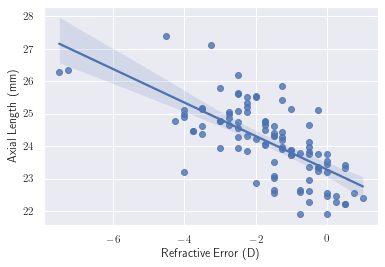

In [49]:
g=sns.regplot(x='RE', y='AL', data=df)
g.set(xlabel='Refractive Error (D)', ylabel='Axial Length (mm)');
print(f'Fig 2. Linear regression analysis of axial length and refractive error. Refractive error showed significantly negative correlation with axial length \
(R 2 = {res.rsquared:.4}, F = {res.fvalue:.3} p = {res.pvalues.AL:.3}), linear equation: y = {res.params.AL:.3}x + {res.params.Intercept:.3}.')

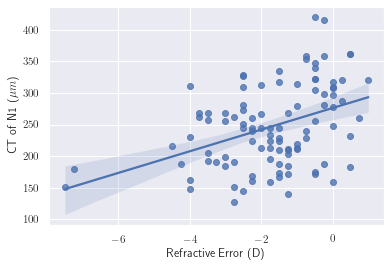

In [50]:
# b)
g = sns.regplot(x='RE', y='N1', data=df)
g.set(xlabel='Refractive Error (D)', ylabel='CT of N1 ($\mu m$)');

In [51]:
resa = stats.pearsonr(df['N1'], df['RE'])

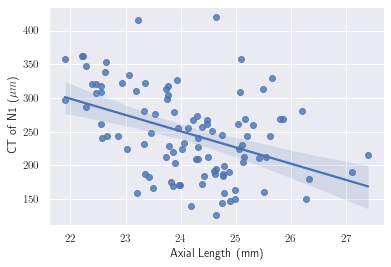

In [52]:
g = sns.regplot(x='AL', y='N1', data=df)
g.set(xlabel='Axial Length (mm)', ylabel='CT of N1 ($\mu m$)');

In [53]:
resb = stats.pearsonr(df['AL'], df['N1'])

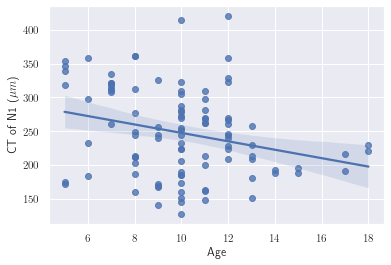

In [54]:
g = sns.regplot(x='Age', y='N1', data=df)
g.set(xlabel='Age', ylabel='CT of N1 ($\mu m$)');

In [55]:
resc = stats.pearsonr(df['Age'], df['N1'])

In [56]:
print(f'Fig 3. The scatter plot graphs showing significant correlation between Choroidal Thickness(CT) of N1 and three factors (refractive error, axial length and age).\
a, CT of N1 negatively correlated with refractive error (diopter) (R 2 = {resa[0]**2:.3}, p = {resa[1]:.3}).b, CT of N1 positively correlated with axial length \
(R 2 = {resb[0]**2:.3}, p = {resb[1]:.3}).c, CT of N1 positively correlated with age (R 2 =  {resc[0]**2:.3}, p = {resc[1]:.3}). N1 = 1 mm nasal to fovea.')

Fig 3. The scatter plot graphs showing significant correlation between Choroidal Thickness(CT) of N1 and three factors (refractive error, axial length and age).a, CT of N1 negatively correlated with refractive error (diopter) (R 2 = 0.162, p = 2.96e-05).b, CT of N1 positively correlated with axial length (R 2 = 0.18, p = 1.01e-05).c, CT of N1 positively correlated with age (R 2 =  0.0709, p = 0.00713). N1 = 1 mm nasal to fovea.


---
>> **TASK**
>>
>> 5. Data cleaning (4 pts)
>>
>>  Clean data with python '~/Documents/bioa/exam/A4/Shao2017_unclean.xlsx'
>>
>> Final cleaned dataset structure should look like: `df`
>>
---

In [57]:
df = pd.read_excel('Shao2017_unclean.xlsx', sheet_name=0)
df

,SEX,AGE (years),OD/OS,DS,DC,axis,spherical equivalence,CORRECTED VA,Axial length
0,male,8,od,0.00,1.25,95.0,0.625,1.0,23.46 mm
1,NaN,8,os,0.00,1.50,80.0,0.750,1.0,23.53 mm
2,fem,13,od,-3.50,-1.50,5.0,-4.250,0.8,24.38 mm
3,NaN,13,os,-4.00,-2.00,175.0,-5.000,0.8,25.11 mm
4,male,10,od,-0.25,0.50,75.0,0.000,1.0,23.33 mm
5,NaN,10,os,-0.50,1.00,90.0,0.000,1.0,23.36 mm
6,male,10,od,-2.50,NaN,NaN,-2.500,1.0,24.29 mm
...,...,...,...,...,...,...,...,...,...
105,NaN,11,os,NaN,3.00,100.0,-2.750,1.0,NaN
106,female,9,od,NaN,0.75,90.0,0.625,1.0,NaN


In [58]:
df['SEX'] = df['SEX'].ffill()
df

,SEX,AGE (years),OD/OS,DS,DC,axis,spherical equivalence,CORRECTED VA,Axial length
0,male,8,od,0.00,1.25,95.0,0.625,1.0,23.46 mm
1,male,8,os,0.00,1.50,80.0,0.750,1.0,23.53 mm
2,fem,13,od,-3.50,-1.50,5.0,-4.250,0.8,24.38 mm
3,fem,13,os,-4.00,-2.00,175.0,-5.000,0.8,25.11 mm
4,male,10,od,-0.25,0.50,75.0,0.000,1.0,23.33 mm
5,male,10,os,-0.50,1.00,90.0,0.000,1.0,23.36 mm
6,male,10,od,-2.50,NaN,NaN,-2.500,1.0,24.29 mm
...,...,...,...,...,...,...,...,...,...
105,female,11,os,NaN,3.00,100.0,-2.750,1.0,NaN
106,female,9,od,NaN,0.75,90.0,0.625,1.0,NaN


In [59]:
df = df.drop(labels=['DC', 'axis'], axis=1)
df

,SEX,AGE (years),OD/OS,DS,spherical equivalence,CORRECTED VA,Axial length
0,male,8,od,0.00,0.625,1.0,23.46 mm
1,male,8,os,0.00,0.750,1.0,23.53 mm
2,fem,13,od,-3.50,-4.250,0.8,24.38 mm
3,fem,13,os,-4.00,-5.000,0.8,25.11 mm
4,male,10,od,-0.25,0.000,1.0,23.33 mm
5,male,10,os,-0.50,0.000,1.0,23.36 mm
6,male,10,od,-2.50,-2.500,1.0,24.29 mm
...,...,...,...,...,...,...,...
105,female,11,os,NaN,-2.750,1.0,NaN
106,female,9,od,NaN,0.625,1.0,NaN


In [60]:
df = df.dropna()
df

,SEX,AGE (years),OD/OS,DS,spherical equivalence,CORRECTED VA,Axial length
0,male,8,od,0.00,0.625,1.0,23.46 mm
1,male,8,os,0.00,0.750,1.0,23.53 mm
2,fem,13,od,-3.50,-4.250,0.8,24.38 mm
3,fem,13,os,-4.00,-5.000,0.8,25.11 mm
4,male,10,od,-0.25,0.000,1.0,23.33 mm
5,male,10,os,-0.50,0.000,1.0,23.36 mm
6,male,10,od,-2.50,-2.500,1.0,24.29 mm
...,...,...,...,...,...,...,...
95,female,10,os,0.25,1.500,1.0,22.29 mm
96,female,7,od,0.25,0.625,1.0,22.46 mm


In [61]:
#df.loc[:,"Axial length"] = pd.to_numeric(df.loc[:,'Axial length'].str.strip('mm'))
df.loc[:,'Axial length'] = pd.to_numeric(df.loc[:,'Axial length'].replace('( mm$)', "", regex=True))

df.head(3)

,SEX,AGE (years),OD/OS,DS,spherical equivalence,CORRECTED VA,Axial length
0,male,8,od,0.0,0.625,1.0,23.46
1,male,8,os,0.0,0.750,1.0,23.53
2,fem,13,od,-3.5,-4.250,0.8,24.38


In [62]:
df.dtypes

SEX                       object
AGE (years)                int64
OD/OS                     object
DS                       float64
spherical equivalence    float64
CORRECTED VA             float64
Axial length             float64
dtype: object

In [63]:
df['SEX'].value_counts() / 2

male      26.0
female    24.0
fem        1.0
Name: SEX, dtype: float64

In [64]:
df.loc[:,'SEX'] = df.loc[:,'SEX'].str.replace('^fem$', 'female')

In [65]:
df.head()

,SEX,AGE (years),OD/OS,DS,spherical equivalence,CORRECTED VA,Axial length
0,male,8,od,0.00,0.625,1.0,23.46
1,male,8,os,0.00,0.750,1.0,23.53
2,female,13,od,-3.50,-4.250,0.8,24.38
3,female,13,os,-4.00,-5.000,0.8,25.11
4,male,10,od,-0.25,0.000,1.0,23.33


In [66]:
df1 = pd.read_excel('Shao2017_unclean.xlsx', sheet_name=1)
df1

,T2 (mikro m),T1 (mikro m),SF (mikro m),N1 (mikro m),N2 (mikro m)
0,289,309,314,248,203
1,274,287,289,277,207
2,191,217,258,257,239
3,186,216,238,230,211
4,339,332,326,281,236
5,347,330,329,322,257
6,324,314,306,273,220
...,...,...,...,...,...
95,299,297,290,287,267
96,313,331,338,321,277


In [67]:
dfALL = pd.concat([df, df1], axis=1)

In [68]:
dfALL.columns = ['Sex', 'Age', 'l/r', 'RE', 'SE',
                 'CV', 'AL', 'T2', 'T1', 'SF', 'N1', 'N2']

In [69]:
dfALL.columns

Index(['Sex', 'Age', 'l/r', 'RE', 'SE', 'CV', 'AL', 'T2', 'T1', 'SF', 'N1',
       'N2'],
      dtype='object')

In [70]:
dfALL

,Sex,Age,l/r,RE,SE,CV,AL,T2,T1,SF,N1,N2
0,male,8,od,0.00,0.625,1.0,23.46,289,309,314,248,203
1,male,8,os,0.00,0.750,1.0,23.53,274,287,289,277,207
2,female,13,od,-3.50,-4.250,0.8,24.38,191,217,258,257,239
3,female,13,os,-4.00,-5.000,0.8,25.11,186,216,238,230,211
4,male,10,od,-0.25,0.000,1.0,23.33,339,332,326,281,236
5,male,10,os,-0.50,0.000,1.0,23.36,347,330,329,322,257
6,male,10,od,-2.50,-2.500,1.0,24.29,324,314,306,273,220
...,...,...,...,...,...,...,...,...,...,...,...,...
95,female,10,os,0.25,1.500,1.0,22.29,299,297,290,287,267
96,female,7,od,0.25,0.625,1.0,22.46,313,331,338,321,277
